In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import coo_matrix
import sklearn.preprocessing as pre
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier,Pool

from datetime import datetime
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.core.display import HTML
import json
import pickle, time

from hyperopt import fmin, tpe, Trials, STATUS_OK, STATUS_FAIL, hp, pyll
import csv
from glob import glob

%load_ext line_profiler

### Bayesian Optimization: feature selections

In [2]:
with open('data.pickle','rb') as f:
    data=pickle.load(f)

In [3]:
x_train=pd.concat([data['train_num'],data['train_tbs']],axis=1)
x_test=pd.concat([data['test_num'],data['test_tbs']],axis=1)
x=pd.concat([x_train,x_test],axis=0)
y_train=data['y_train']
y_test=data['y_test']
y=pd.concat([y_train,y_test],axis=0)
xE1=x.iloc[np.where(y==1)[0].tolist()]
xdesc=xE1.describe().T
colsZeroMean=[]
_=[colsZeroMean.append(col) for col in xdesc.iloc[np.where((xdesc['mean']==0) & (xdesc['std'] ==0))[0]].index]
#colsZeroMean

In [4]:
print(x_train.shape)
x_train.drop(labels=colsZeroMean,axis=1,inplace=True)
x_test.drop(labels=colsZeroMean,axis=1,inplace=True)
print(x_train.shape)

(45000, 422)
(45000, 394)


In [5]:
def feature_importance_all(run_time_saved):
    fdir='cv_run/'+run_time_saved
    files=glob(fdir+'/feature*')
    feature_importance=dict()
    for f in files:
        cols=[]
        vals=[]
        feat_imp=dict()
        feature=pd.read_pickle(f)
        for key, val in feature.items():
            cols.append(key)
            vals.append(val)
        feat_imp.update({'columns':cols})
        feat_imp.update({'importance':vals})
        cnt=f.split('.')[1]+'.'+f.split('.')[2]
        feature_importance.update({cnt:feat_imp})
    return feature_importance

def feature_importance_run(runid):
    global feature_importance
    #print(feature_importance[runid]['columns'])
    cols=feature_importance[runid]['columns']
    vals=feature_importance[runid]['importance']
    idx=np.where(np.array(vals)>0)
    cols=(np.array(cols))[idx]
    _cols=[]
    for col in cols:
        if '_imputed' not in col:
            _cols.append(col)
    return _cols

In [6]:
def set_parameters(iterations=201,
        depth=6,
        thread_count=8,
        learning_rate=0.03,
        loss_function='Logloss',
        fold_len_multiplier = 2,
        rsm = 1,
        border_count = 128,
        max_ctr_complexity = 2,
        l2_leaf_reg = 3,
        leaf_estimation_method = 'Newton',
        leaf_estimation_iterations = 10,
        random_strength = 1,
        one_hot_max_size = 0,
        bagging_temperature = 1,
        logging_level = 'Verbose',
        eval_metric = 'AUC',
        custom_loss = ['Accuracy','Precision','Recall'],
        random_seed=300,
        metric_period=50,
        calc_feature_importance = True,
        task_type = 'CPU',
        #class_weights = (1,4)
              ):
    params=dict(iterations=iterations,
        depth=depth,
        thread_count=thread_count,
        learning_rate=learning_rate,
        loss_function=loss_function,
        fold_len_multiplier = fold_len_multiplier,
        rsm = rsm,
        border_count = border_count,
        max_ctr_complexity=max_ctr_complexity,
        l2_leaf_reg = l2_leaf_reg,
        leaf_estimation_method = leaf_estimation_method,
        leaf_estimation_iterations = leaf_estimation_iterations,
        random_strength = random_strength,
        one_hot_max_size = one_hot_max_size,
        bagging_temperature = bagging_temperature,
        #ctr_description = 'Borders',
        logging_level = logging_level,
        eval_metric = eval_metric,
        #train_dir=strnow,
        custom_loss = custom_loss,
        random_seed=random_seed,
        metric_period=metric_period,
        calc_feature_importance = metric_period,
        task_type=task_type,
        #class_weights=class_weights
               )
    return params
params=set_parameters(eval_metric='AUC')

In [7]:
def split_pair(x,y,n_splits=5,klas=1, cat_cols=[]):
    #global col_cat
    split_pair=[]
    split_pair_raw=[]
    split=StratifiedKFold(n_splits, shuffle=True, random_state=0)

    if len(cat_cols)>0:
        col_cat_idx=[]
        cols=x.columns.tolist()
        _=[ col_cat_idx.append(cols.index(col)) for col in cat_cols]

    for train_idx, test_idx in split.split(x,y):
        _x=x.iloc[train_idx]
        _y=y.iloc[train_idx]
        _xt=x.iloc[test_idx]
        _yt=y.iloc[test_idx]
        
        if len(cat_cols) > 0:
            trainp=Pool(_x,_y,cat_features=col_cat_idx)
            testp=Pool(_xt,_yt,cat_features=col_cat_idx)
        else:
            trainp=Pool(_x,_y)
            testp=Pool(_xt,_yt)
        split_pair.append((trainp,testp))
        #split_pair_raw.append(((trainx,trainy),(testx,testy)))
    return split_pair, None

In [8]:
space={'category_data': hp.choice('category',['tbs','non']),
        'numerical_data': hp.choice('numeric',['normal','non'])
                               }
param_space = {
            'depth': hp.choice('depth', [2,4,6]),
            'border_count': hp.choice('border_count', [64,128]),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),
            'random_strength': hp.choice('random_strength', [1,  20]),
            'one_hot_max_size': hp.choice('one_hot_max_size', [0, 25]),
            'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
            'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
            'leaf_estimation_iterations':hp.choice('leaf_estimation_iterations',[1,3,5,7,10]),
            'max_ctr_complexity':hp.quniform('max_ctr_complexity',1,5,1),
            'leaf_estimation_method':hp.choice('leaf_estimation_method',['Newton','Gradient']),
            'class_weights': (hp.choice('non_class_weights_ratio',[1]), hp.uniform('class_weights_ratio',1,20))
    
        }

space.update({'param_space':param_space})
feature_space={}
cols=data['category_columns']+data['numeric_columns']
_=[feature_space.update({col : eval("hp.choice('"+ col + "',[0,1])")}) for col in cols]

space.update({'feature_space':feature_space})
#space.update({'data':data})

In [9]:
space2={'category_data': hp.choice('category',['non']),
        'numerical_data': hp.choice('numeric',['normal','non'])
                               }
param_space = {
            'depth': hp.choice('depth', [4,6,8]),
            'border_count': hp.choice('border_count', [64,128]),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),
            'random_strength': hp.choice('random_strength', [1,  20]),
            'one_hot_max_size': hp.choice('one_hot_max_size', [0, 25]),
            'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
            'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
            'leaf_estimation_iterations':hp.choice('leaf_estimation_iterations',[1,3,5,7,10]),
            'max_ctr_complexity':hp.quniform('max_ctr_complexity',1,5,1),
            'leaf_estimation_method':hp.choice('leaf_estimation_method',['Newton','Gradient']),
            'class_weights': (hp.choice('non_class_weights_ratio',[1]), hp.uniform('class_weights_ratio',1,20))
    
        }

space2.update({'param_space':param_space})
#feature_space={}
#cols=data['category_columns']+data['numeric_columns']
#_=[feature_space.update({col : eval("hp.choice('"+ col + "',[0,1])")}) for col in cols]

#space2.update({'feature_space':feature_space})

In [10]:
def fit(params=None, dtrain=None, dtest=None, n_estimators=None, seed=0, run_time=None, run_cv_id=0, eval_no=0, verbose=False):
    global metric,column_names
    #print(run_cv_id, eval_no)
    path="./cv_run/"+str(run_time)
    if not os.path.isdir(path):
        os.mkdir(path)
    fpath=path+"/"+str(eval_no)+"."+str(run_cv_id)
    if not os.path.isdir(fpath):
        os.mkdir(fpath)    
    params.update({"iterations": n_estimators})
    params.update({"eval_metric": metric})
    params.update({"logging_level": 'Silent'})
    #params.update({"metric_period": 100})
    params.update({"random_seed": seed})
    #params.update({"leaf_estimation_method": "Newton"})
    #params.update({"leaf_estimation_iterations" : 10})
    params.update({"rsm" : 1})
    params.update({"thread_count" : 8})
    params.update({"fold_len_multiplier": 2})
    #params.update({"max_ctr_complexity":5})
    params.update({"train_dir": fpath})
    params.update({"calc_feature_importance" : True})
    params.update({'od_type':'Iter'})
    params.update({'od_wait':30})
    
    bst = CatBoostClassifier(**params)
    bst.fit(dtrain, eval_set=dtest, use_best_model=True)
    with open(fpath + "/test_error.tsv", "r") as f:
        reader=np.array(list(csv.reader(f,delimiter='\t'))).squeeze()
    header=reader[0]
    feature=dict()
    for col, val in zip(column_names,bst.__dict__['_feature_importance']):
        feature.update({col:val})
    #pd.to_pickle(bst.__dict__['_feature_importance'],path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    pd.to_pickle(feature,path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    idx=(header==metric).argmax()
    results=(reader[1:reader.shape[0],idx]).astype(np.float)
    if metric=='AUC':
        results=1-results
        
    return bst, results

In [11]:
def mean_each_iter(results):
    lengs=[]
    _=[lengs.append(len(res)) for res in results]
    mlen=np.max(lengs)
    #print(lengs,mlen)
    a=[]
    for run in results:
        a.append((np.pad(run,(0,mlen-len(run)),'constant')).tolist())
    x=np.array(a)
    #print(x.shape)
    means=[]
    for i in range(x.shape[1]):
        mean=0
        count=0
        for j in range(x.shape[0]):
            if x[j,i] > 0:
                count=count+1
                mean=mean+x[j,i]
        means.append(mean/count)
    return means

In [12]:
def run_cv(cv_pairs, params=None, n_est=None, verbose=False, run_time=None):
    global default_params,n_estimators,best_loss,hyperopt_eval_num,metric,hyperopt_evals
    params = params or default_params
    n_estimators = n_est or n_estimators
    #print('run_cv',hyperopt_eval_num)
    evals_results, start_time = [], time.time()
    _loss=[]
    i=0
    for dtrain, dtest in cv_pairs:
        _, evals_result = fit(params, dtrain, dtest, n_estimators, run_time=run_time, run_cv_id=i, eval_no=hyperopt_eval_num+1)
        #evals_results.append(np.mean(evals_result,axis=0))
        evals_results.append(evals_result)
        _loss.append(np.min(evals_result))
        i=i+1
    mean_evals_results = mean_each_iter(evals_results)
    best_n_estimators = np.argmin(mean_evals_results) + 1
    eval_time = time.time() - start_time
    
    
    cv_result = {'loss': mean_evals_results[best_n_estimators - 1] ,
                 'best_n_estimators': best_n_estimators, 
                 'eval_time': eval_time,
                 'status': STATUS_FAIL if np.isnan(mean_evals_results[best_n_estimators - 1]) else STATUS_OK,
                 'params': params.copy(),
                 'losses': _loss
                }
    best_loss = min(best_loss, cv_result['loss'])
    hyperopt_eval_num += 1
    cv_result.update({'hyperopt_eval_num': hyperopt_eval_num, 'best_loss': best_loss})
        
    if verbose:
        print ('[{0}/{1}]\teval_time={2:.2f} sec\tcurrent_{3}={4:.6f}\tmin_{3}={5:.6f}'.format(
                    hyperopt_eval_num, hyperopt_evals, eval_time,
                    metric, cv_result['loss'], best_loss))
    return cv_result

n_estimators=50
hyperopt_evals=0
metric="AUC"
evals_results=[]
space_sample=pyll.stochastic.sample(space2)
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
params=None
hyperopt_eval_num, best_loss = 0, np.inf
res=run_hyper_test2(space_sample,data,run_time)

In [13]:
column_names=x_train.columns.tolist()
cv_pair,_=split_pair(x_train,y_train)

In [23]:
n_estimators=501
hyperopt_evals=0
metric="AUC"
max_evals = 20
this_trials = Trials()
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
hyperopt_eval_num, best_loss, split_pair_data = 0, np.inf, None
args=space2['param_space'] #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_cv(cv_pair, params=args, n_est=n_estimators, verbose=True,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/0]	eval_time=73.32 sec	current_AUC=0.452720	min_AUC=0.452720
[2/0]	eval_time=84.26 sec	current_AUC=0.461085	min_AUC=0.452720
[3/0]	eval_time=38.65 sec	current_AUC=0.471458	min_AUC=0.452720
[4/0]	eval_time=55.04 sec	current_AUC=0.466392	min_AUC=0.452720
[5/0]	eval_time=45.42 sec	current_AUC=0.494950	min_AUC=0.452720
[6/0]	eval_time=35.32 sec	current_AUC=0.478284	min_AUC=0.452720
[7/0]	eval_time=71.99 sec	current_AUC=0.473927	min_AUC=0.452720
[8/0]	eval_time=73.86 sec	current_AUC=0.478626	min_AUC=0.452720
[9/0]	eval_time=63.29 sec	current_AUC=0.458949	min_AUC=0.452720
[10/0]	eval_time=40.66 sec	current_AUC=0.472771	min_AUC=0.452720
[11/0]	eval_time=32.67 sec	current_AUC=0.475612	min_AUC=0.452720
[12/0]	eval_time=39.13 sec	current_AUC=0.469635	min_AUC=0.452720
[13/0]	eval_time=55.34 sec	current_AUC=0.474333	min_AUC=0.452720
[14/0]	eval_time=34.98 sec	current_AUC=0.470496	min_AUC=0.452720
[15/0]	eval_time=52.17 sec	current_AUC=0.466942	min_AUC=0.452720
[16/0]	eval_time=60.85 sec	current

In [14]:
n_estimators=501
hyperopt_evals=40
metric="Logloss"
max_evals = 40
this_trials = Trials()
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
hyperopt_eval_num, best_loss, split_pair_data = 0, np.inf, None
args=space2['param_space'] #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_cv(cv_pair, params=args, n_est=n_estimators, verbose=True,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/40]	eval_time=83.25 sec	current_Logloss=0.364518	min_Logloss=0.364518
[2/40]	eval_time=260.52 sec	current_Logloss=0.252645	min_Logloss=0.252645
[3/40]	eval_time=144.45 sec	current_Logloss=0.414332	min_Logloss=0.252645
[4/40]	eval_time=79.10 sec	current_Logloss=0.291346	min_Logloss=0.252645
[5/40]	eval_time=331.28 sec	current_Logloss=0.441436	min_Logloss=0.252645
[6/40]	eval_time=199.96 sec	current_Logloss=0.460638	min_Logloss=0.252645
[7/40]	eval_time=61.31 sec	current_Logloss=0.538487	min_Logloss=0.252645
[8/40]	eval_time=143.77 sec	current_Logloss=0.326684	min_Logloss=0.252645
[9/40]	eval_time=43.22 sec	current_Logloss=0.217205	min_Logloss=0.217205
[10/40]	eval_time=89.31 sec	current_Logloss=0.411586	min_Logloss=0.217205
[11/40]	eval_time=135.76 sec	current_Logloss=0.530839	min_Logloss=0.217205
[12/40]	eval_time=82.05 sec	current_Logloss=0.179478	min_Logloss=0.179478
[13/40]	eval_time=67.70 sec	current_Logloss=0.521002	min_Logloss=0.179478
[14/40]	eval_time=521.75 sec	current_Logl

In [15]:
with open('this_trials.'+run_time+'.pickle','wb') as f:
    pickle.dump(this_trials,f)

In [16]:
_params=this_trials.best_trial['result']['params']
cols=x_train.columns.tolist()
trainp=Pool(x_train,label=y_train)
testp=Pool(x_test,label=y_test)

In [56]:
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
model,result=fit(params=_params,dtrain=trainp,dtest=testp,n_estimators=2001,run_time=run_time)

In [57]:
from sklearn import metrics

In [58]:
pred=model.predict(trainp)
metrics.accuracy_score(y_train,pred)

0.9822

In [59]:
pred=model.predict(testp)
metrics.accuracy_score(y_test,pred)

0.9822

In [60]:
res=model.eval_metrics(testp,['Logloss','AUC'])
loss=res['Logloss'][(len(res['Logloss'])-1)]
print(loss)

0.08956276933429051


In [74]:
pred=model.predict(testp,ntree_start=0,ntree_end=2)

In [75]:
(pred!=0).sum()

0

In [69]:
model.save_model("model.catboost."+run_time)

In [70]:
from sklearn.metrics import confusion_matrix
def confusion_mat(y_test,y_pred):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test,y_pred).ravel()
    print("Actual\t\t|  Pos     |   Neg    |")
    print("Predicted\t-----------------")
    print("Pos\t\t| {0:08d} | {1:08d} |".format(true_positive,false_positive))
    print("Neg\t\t| {0:08d} | {1:08d} |\n".format(false_negative,true_negative))

In [71]:
confusion_mat(y_test,pred)

Actual		|  Pos     |   Neg    |
Predicted	-----------------
Pos		| 00000000 | 00000000 |
Neg		| 00000089 | 00004911 |



In [44]:
def evaluate_col(col,x,x_test,y_test,model):
    #global x,x_test,model
    x_col=x[col]
    _col=x_col.sample(frac=1.0,replace=True).values
    x[col]=_col
    xpool=None
    xpool=Pool(x,y_test)
    res=model.eval_metrics(xpool,['Logloss'])
    x[col]=x_test[col]    
    return res

In [45]:
def column_pertubation(model,x_test,y_test):
    xtestp=Pool(x_test,y_test)
    res=model.eval_metrics(xtestp,['Logloss'])
    min_loss=np.min(res['Logloss'])
    min_loss_arg=np.argmin(res['Logloss'])
    #print(min_loss,min_loss_arg)
    x=x_test.copy()
    loss_gains=[]
    for col in x_test.columns:
        _res=evaluate_col(col,x,x_test,y_test,model)
        _loss=_res['Logloss'][(len(_res['Logloss'])-1)]
        _min_loss=np.min(_res['Logloss'])
        _min_loss_arg=np.argmin(_res['Logloss'])
        #print(col,loss_gain,_min_loss,_min_loss_arg,_min_loss/min_loss)
        loss_gains.append([col,_min_loss,_min_loss/min_loss,(_min_loss/min_loss)-1])
    pd_loss_gains=pd.DataFrame(loss_gains,columns=['Feature','Loss','ratio','gains'],index=x_test.columns)
    return pd_loss_gains

In [47]:
losses=column_pertubation(model,x_test,y_test)

In [50]:
losses.head()

,Feature,Loss,ratio,gains
Var1,Var1,0.090030,0.999935,-0.000065
Var3,Var3,0.090038,1.000021,0.000021
Var4,Var4,0.090036,0.999998,-0.000002
Var5,Var5,0.090050,1.000148,0.000148
Var6,Var6,0.090039,1.000031,0.000031


In [53]:
losses['ratio']=losses['Loss']/np.max(losses['Loss'])

In [55]:
losses.sort_values(['ratio'],ascending=False)

,Feature,Loss,ratio,gains
Var123_imputed,Var123_imputed,0.090117,1.000000,0.000894
Var21_imputed,Var21_imputed,0.090101,0.999829,0.000724
Var25_imputed,Var25_imputed,0.090101,0.999821,0.000715
Var78_imputed,Var78_imputed,0.090086,0.999657,0.000551
Var81,Var81,0.090086,0.999655,0.000549
Var28_imputed,Var28_imputed,0.090084,0.999632,0.000526
Var132_imputed,Var132_imputed,0.090080,0.999592,0.000486
Var74_imputed,Var74_imputed,0.090077,0.999554,0.000449
Var35_imputed,Var35_imputed,0.090075,0.999542,0.000436
Var72_imputed,Var72_imputed,0.090074,0.999530,0.000424


In [47]:
def train_selected_colums(selected_col,x_train=x_train,x_test=x_test,y_train=y_train,y_test=y_test):
    x_train2=x_train[selected_col]
    x_test2=x_test[selected_col] 
    cv_pair,_=split_pair(x_train2,y_train)
    n_estimators=501
    hyperopt_evals=20
    metric="AUC"
    max_evals = 20
    this_trials = Trials()
    run_time=(datetime.now()).strftime('%Y%m%d%H%M')
    args=space2['param_space'] #or pyll.stochastic.sample(space)
    _ = fmin(fn=lambda args: run_cv(cv_pair, params=args, n_est=n_estimators, verbose=True,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)
    with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
        pickle.dump(this_trials,f)
    return this_trials

In [43]:
selected_col=(losses[np.abs(losses['gains'])>0]).index

In [48]:
trials=trian_selected_colums(selected_col=selected_col)

[21/0]	eval_time=107.16 sec	current_Logloss=0.505585	min_Logloss=0.112904
[22/0]	eval_time=8.98 sec	current_Logloss=0.559469	min_Logloss=0.112904
[23/0]	eval_time=95.07 sec	current_Logloss=0.545702	min_Logloss=0.112904
[24/0]	eval_time=50.71 sec	current_Logloss=0.560086	min_Logloss=0.112904
[25/0]	eval_time=42.85 sec	current_Logloss=0.561631	min_Logloss=0.112904
[26/0]	eval_time=100.30 sec	current_Logloss=0.429839	min_Logloss=0.112904
[27/0]	eval_time=94.25 sec	current_Logloss=0.419326	min_Logloss=0.112904
[28/0]	eval_time=17.30 sec	current_Logloss=0.125615	min_Logloss=0.112904


KeyboardInterrupt: 

In [49]:
x_train2=x_train[selected_col]
x_test2=x_test[selected_col] 
cv_pair,_=split_pair(x_train2,y_train)

In [50]:
n_estimators=501
hyperopt_evals=20
metric="AUC"
max_evals = 20
this_trials = Trials()
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
hyperopt_eval_num, best_loss, split_pair_data = 0, np.inf, None
args=space2['param_space'] #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_cv(cv_pair, params=args, n_est=n_estimators, verbose=True,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/20]	eval_time=6.76 sec	current_AUC=0.491687	min_AUC=0.491687
[2/20]	eval_time=11.70 sec	current_AUC=0.498515	min_AUC=0.491687
[3/20]	eval_time=7.20 sec	current_AUC=0.492917	min_AUC=0.491687
[4/20]	eval_time=8.94 sec	current_AUC=0.498470	min_AUC=0.491687
[5/20]	eval_time=20.71 sec	current_AUC=0.462522	min_AUC=0.462522
[6/20]	eval_time=13.14 sec	current_AUC=0.494547	min_AUC=0.462522
[7/20]	eval_time=8.80 sec	current_AUC=0.497130	min_AUC=0.462522
[8/20]	eval_time=9.06 sec	current_AUC=0.492496	min_AUC=0.462522
[9/20]	eval_time=13.61 sec	current_AUC=0.472812	min_AUC=0.462522
[10/20]	eval_time=12.74 sec	current_AUC=0.492047	min_AUC=0.462522
[11/20]	eval_time=8.10 sec	current_AUC=0.493948	min_AUC=0.462522
[12/20]	eval_time=7.26 sec	current_AUC=0.492955	min_AUC=0.462522
[13/20]	eval_time=12.44 sec	current_AUC=0.497207	min_AUC=0.462522
[14/20]	eval_time=12.56 sec	current_AUC=0.480586	min_AUC=0.462522
[15/20]	eval_time=10.46 sec	current_AUC=0.491292	min_AUC=0.462522
[16/20]	eval_time=10.24 se

In [54]:
n_estimators=1001
hyperopt_evals=20
metric="Logloss"
max_evals = 40
this_trials2 = Trials()
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
hyperopt_eval_num, best_loss, split_pair_data = 0, np.inf, None
args=space2['param_space'] #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_cv(cv_pair, params=args, n_est=n_estimators, verbose=True,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials2)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/20]	eval_time=195.17 sec	current_Logloss=0.404364	min_Logloss=0.404364
[2/20]	eval_time=12.39 sec	current_Logloss=0.440029	min_Logloss=0.404364
[3/20]	eval_time=37.90 sec	current_Logloss=0.096958	min_Logloss=0.096958
[4/20]	eval_time=12.85 sec	current_Logloss=0.437329	min_Logloss=0.096958
[5/20]	eval_time=50.45 sec	current_Logloss=0.489967	min_Logloss=0.096958
[6/20]	eval_time=30.28 sec	current_Logloss=0.508005	min_Logloss=0.096958
[7/20]	eval_time=201.38 sec	current_Logloss=0.453918	min_Logloss=0.096958
[8/20]	eval_time=26.72 sec	current_Logloss=0.322000	min_Logloss=0.096958
[9/20]	eval_time=112.61 sec	current_Logloss=0.532338	min_Logloss=0.096958
[10/20]	eval_time=200.88 sec	current_Logloss=0.257821	min_Logloss=0.096958
[11/20]	eval_time=3677.57 sec	current_Logloss=0.421811	min_Logloss=0.096958
[12/20]	eval_time=77.52 sec	current_Logloss=0.235448	min_Logloss=0.096958
[13/20]	eval_time=55.51 sec	current_Logloss=0.425873	min_Logloss=0.096958
[14/20]	eval_time=27.10 sec	current_Loglo

In [111]:
_params=this_trials2.trials[4]['result']['params']
trainp=Pool(x_train2,label=y_train)
testp=Pool(x_test2,label=y_test)
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
model3,result=fit(params=_params,dtrain=trainp,dtest=testp,n_estimators=501,run_time=run_time)
res=model3.eval_metrics(testp,['Logloss','AUC'])
print(np.min(res['Logloss']),np.max(res['AUC']))

{'Logloss': [0.4277268230795688, 0.29442362808665784, 0.22307939896450266, 0.18186405446467332, 0.15648776506661224, 0.13989948882479755, 0.12853733589109825, 0.12047655908336069, 0.11456271095522397, 0.11011733848264678, 0.10670143179513561, 0.10402875442284855, 0.10186404548328769, 0.10014704621393915, 0.09871871648809197, 0.09756932346620702, 0.0965994948395265, 0.09576000741327383, 0.09508566344910202, 0.09450301161974223, 0.09400612462671709, 0.09358681337512492, 0.09321050268288002, 0.09288280613599796, 0.0926007226860743, 0.09234910660464656, 0.09213137268000753, 0.09193280493905268, 0.09176196619751804, 0.09160999522118801, 0.09145637155847995, 0.09133174625512898, 0.09119214547172205, 0.09107846084072141, 0.0909752652403107, 0.09084001564932377, 0.09078442219395731, 0.0907200535966977, 0.09065668033448582, 0.09058010600070268, 0.09054382649936736, 0.09050459688860228, 0.09046353178143236, 0.09042350727262574, 0.09038351131655889, 0.09037542775762483, 0.09037043102800046, 0.090

In [112]:
print(np.min(res['Logloss']),np.max(res['AUC']))

0.0897563676875628 0.5537854712763597


In [115]:
xtestp=Pool(x_test2,y_test)
res=model3.eval_metrics(xtestp,['Logloss'])
#res=model.eval_metrics(testp,['Logloss','AUC'])
min_loss=np.min(res['Logloss'])
min_loss_arg=np.argmin(res['Logloss'])
print(min_loss,min_loss_arg)
x=x_test2.copy()
loss_gains=[]
for col in x_test2.columns:
    _res=evaluate_col(col,x,x_test2,y_test,model3)
    _loss=_res['Logloss'][(len(_res['Logloss'])-1)]
    _min_loss=np.min(_res['Logloss'])
    _min_loss_arg=np.argmin(_res['Logloss'])
    #print(col,loss_gain,_min_loss,_min_loss_arg,_min_loss/min_loss)
    loss_gains.append([col,_min_loss,_min_loss/min_loss,(_min_loss/min_loss)-1])

pd_loss_gains=pd.DataFrame(loss_gains,columns=['Feature','Loss','ratio','gains'],index=x_test2.columns)

0.0897563676875628 81


In [118]:
pd_loss_gains.sort_values(['gains'],ascending=False)

,Feature,Loss,ratio,gains
Var13_imputed,Var13_imputed,0.091877,1.023626,0.023626
Var38_imputed,Var38_imputed,0.091222,1.016324,0.016324
Var72_imputed,Var72_imputed,0.090803,1.011662,0.011662
Var154_imputed,Var154_imputed,0.090236,1.005345,0.005345
Var21,Var21,0.090083,1.003643,0.003643
Var140_imputed,Var140_imputed,0.090077,1.003576,0.003576
Var24_imputed,Var24_imputed,0.090070,1.003490,0.003490
Var103,Var103,0.090024,1.002982,0.002982
Var29_imputed,Var29_imputed,0.090003,1.002753,0.002753
Var22_imputed,Var22_imputed,0.089990,1.002601,0.002601


In [140]:
pred=model3.predict(x_train2)
(pred!=0).sum()

1

In [136]:
_params=this_trials2.trials[18]['result']['params']
trainp=Pool(x_train2,label=y_train)
testp=Pool(x_test2,label=y_test)
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
model4,result=fit(params=_params,dtrain=trainp,dtest=testp,n_estimators=501,run_time=run_time)
res=model4.eval_metrics(testp,['Logloss','AUC'])
print(np.min(res['Logloss']),np.max(res['AUC']),np.argmax(res['AUC']))

0.10611579386124535 0.563275746489765 7


In [129]:
for i in range(20):
    _params=this_trials2.trials[i]['result']['params']
    trainp=Pool(x_train2,label=y_train)
    testp=Pool(x_test2,label=y_test)
    #run_time=(datetime.now()).strftime('%Y%m%d%H%M')
    model4,result=fit(params=_params,dtrain=trainp,dtest=testp,n_estimators=501,run_time=run_time)
    res=model4.eval_metrics(testp,['Logloss','AUC'])
    print(i,np.min(res['Logloss']),np.max(res['AUC']))

0 0.2903699832023646 0.5269390659354487
1 0.18508738975275824 0.5449769950054796
2 0.28016044733153844 0.5619727783764491
3 0.25770335215685813 0.5378741600488699
4 0.0897563676875628 0.5537854712763597
5 0.2193472006412915 0.5431603897693552
6 0.23698829489269224 0.5477854117905459
7 0.21757901931250448 0.5489716961922215
8 0.19557604781729732 0.5466666209083484
9 0.16063337933856986 0.5592181276153739
10 0.18013548128477175 0.5504485459150406
11 0.09326206356358023 0.5548196092697202
12 0.10225281187206911 0.528367869424063
13 0.27360733297277373 0.5514174783048373
14 0.30120191250127043 0.5539318978948886
15 0.12396593606734678 0.5620036652412951
16 0.20127920316890022 0.5486353725527879
17 0.11577213817250777 0.5600852477469749
18 0.10611579386124535 0.563275746489765
19 0.2392740105639319 0.5425415085144791


In [131]:
trainp=Pool(x_train2,label=y_train)
testp=Pool(x_test2,label=y_test)
for i in range(20):
    _params=this_trials.trials[i]['result']['params']
    #trainp=Pool(x_train2,label=y_train)
    #testp=Pool(x_test2,label=y_test)
    #run_time=(datetime.now()).strftime('%Y%m%d%H%M')
    model4,result=fit(params=_params,dtrain=trainp,dtest=testp,n_estimators=501,run_time=run_time)
    res=model4.eval_metrics(testp,['Logloss','AUC'])
    print(i,np.min(res['Logloss']),np.max(res['AUC']),np.argmax(res['AUC']))

0 0.11938809290062177 0.5326531359319482 34
1 0.3161315792705446 0.5467592815028862 4
2 0.1767237980171387 0.5450810951795899 2
3 0.320343109727721 0.5276300165416321 4
4 0.14038285418842983 0.5490060149309393 75
5 0.1098728607278975 0.5237131044959835 4
6 0.1405222520154462 0.5631384715348942 2
7 0.1385115570167563 0.5376488003312903 0
8 0.20724260455453208 0.5546697507773195 148
9 0.12329385249945556 0.5499154615069587 9
10 0.236365761226885 0.547839177814537 3
11 0.3019953893496173 0.5376488003312903 0
12 0.19942217640467844 0.51657023101087 14
13 0.18336319634957854 0.55569130523315 123
14 0.2684785134756219 0.550041296882257 9
15 0.08982621032298467 0.572541805943548 6
16 0.1707654111841392 0.5328155779618788 0
17 0.2601889243578647 0.5584196449612084 16
18 0.12459315178475733 0.541340352659359 4
19 0.2566187853034362 0.551082298623361 1


In [138]:
x_test2.columns

Index(['Var5', 'Var10', 'Var21', 'Var28', 'Var34', 'Var59', 'Var71', 'Var81',
       'Var88', 'Var99', 'Var103', 'Var130', 'Var136', 'Var140', 'Var149',
       'Var162', 'Var165', 'Var172', 'Var183', 'Var197', 'Var201', 'Var206',
       'Var224', 'Var225', 'Var1_imputed', 'Var4_imputed', 'Var6_imputed',
       'Var13_imputed', 'Var14_imputed', 'Var22_imputed', 'Var24_imputed',
       'Var29_imputed', 'Var34_imputed', 'Var35_imputed', 'Var38_imputed',
       'Var46_imputed', 'Var49_imputed', 'Var59_imputed', 'Var60_imputed',
       'Var72_imputed', 'Var76_imputed', 'Var85_imputed', 'Var90_imputed',
       'Var94_imputed', 'Var95_imputed', 'Var105_imputed', 'Var108_imputed',
       'Var120_imputed', 'Var123_imputed', 'Var125_imputed', 'Var132_imputed',
       'Var139_imputed', 'Var140_imputed', 'Var142_imputed', 'Var143_imputed',
       'Var151_imputed', 'Var154_imputed', 'Var160_imputed', 'Var171_imputed',
       'Var174_imputed', 'Var189_imputed'],
      dtype='object')

In [133]:
this_trials.trials[14]['result']['params']

{'bagging_temperature': 0.6360830384671156,
 'border_count': 128,
 'class_weights': (1, 15.39192339060007),
 'depth': 8,
 'l2_leaf_reg': 1.6561896117976493,
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10383569528314504,
 'max_ctr_complexity': 3.0,
 'one_hot_max_size': 0,
 'random_strength': 1,
 'iterations': 501,
 'eval_metric': 'Logloss',
 'logging_level': 'Silent',
 'random_seed': 0,
 'rsm': 1,
 'thread_count': 8,
 'fold_len_multiplier': 2,
 'train_dir': './cv_run/201809141356/0.0',
 'calc_feature_importance': True,
 'od_type': 'Iter',
 'od_wait': 30}

In [137]:
this_trials2.trials[17]['result']['params']

{'bagging_temperature': 0.7242644466027569,
 'border_count': 64,
 'class_weights': (1, 3.899492351596896),
 'depth': 6,
 'l2_leaf_reg': 8.197734346168204,
 'leaf_estimation_iterations': 5,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.7250153244222955,
 'max_ctr_complexity': 3.0,
 'one_hot_max_size': 25,
 'random_strength': 1,
 'iterations': 501,
 'eval_metric': 'Logloss',
 'logging_level': 'Silent',
 'random_seed': 0,
 'rsm': 1,
 'thread_count': 8,
 'fold_len_multiplier': 2,
 'train_dir': './cv_run/201809141412/0.0',
 'calc_feature_importance': True,
 'od_type': 'Iter',
 'od_wait': 30}

In [19]:
n_estimators=401

metric="AUC"
to_run=8

run_time_saved='201808031235'
run_time=(datetime.now()).strftime('%Y%m%d%H%M')

with open('./cv_run/'+run_time_saved+'/trails.pickle','rb') as f:
    this_trials=pickle.load(f)
    max_evals=to_run+len(this_trials.trials)
    #print(max_evals)
#this_trials=this_trials
#max_evals = max_evals + to_run # last run + # additional run
hyperopt_evals=len(this_trials.trials)

hyperopt_eval_num, best_loss = 0, this_trials.best_trial['result']['loss']
args=space2 #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_hyper_test2(args,data,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/4]	eval_time=265.51 sec	current_AUC=0.478115	min_AUC=0.445421
[2/4]	eval_time=123.29 sec	current_AUC=0.493398	min_AUC=0.445421
[3/4]	eval_time=57.36 sec	current_AUC=0.468019	min_AUC=0.445421
[4/4]	eval_time=421.49 sec	current_AUC=0.472625	min_AUC=0.445421
[5/4]	eval_time=91.08 sec	current_AUC=0.470613	min_AUC=0.445421
[6/4]	eval_time=200.46 sec	current_AUC=0.474690	min_AUC=0.445421
[7/4]	eval_time=71.52 sec	current_AUC=0.448925	min_AUC=0.445421
[8/4]	eval_time=177.51 sec	current_AUC=0.480839	min_AUC=0.445421


In [124]:
cols=data['numeric_columns'] + data['category_columns']
features=[]
klas=1
for _dir in os.listdir("cv_run"):
    if not os.path.isdir("cv_run/"+_dir):
        continue
    for file in os.listdir("cv_run/"+_dir):
        #print(file)
        if file.startswith('feature'):
            features.append(pd.read_pickle("cv_run/"+_dir+"/"+file))

In [127]:
feature_matrix=[]
for f in features:
    matrix=[]
    for col in cols:
        try:
            matrix.append(f[col])
        except KeyError:
            matrix.append(0)
    feature_matrix.append(matrix)

loss=[]
for t in this_trials.trials:
    loss.append(t['result']['losses'])
        
loss=np.squeeze(np.array(loss))
loss=loss.flatten()
y=[]
_=[y.append(i) for i in range(len(loss))]

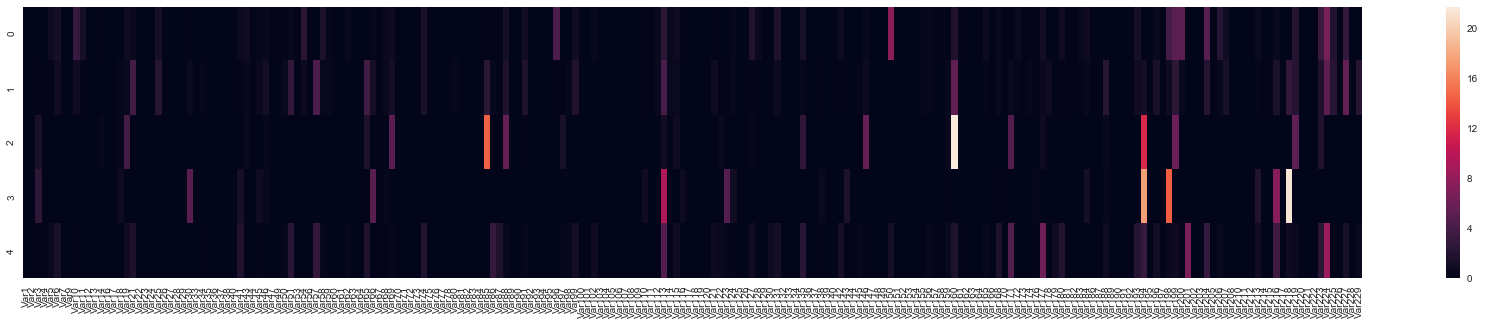

In [143]:
features=np.squeeze(np.array(feature_matrix))
plt.figure(figsize=(30,5))
ax=sns.heatmap(features[10:15,:],xticklabels=cols)
plt.show()

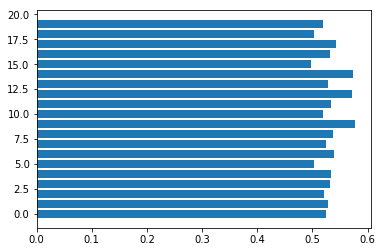

In [132]:
plt.barh(y,1-loss)
plt.show()

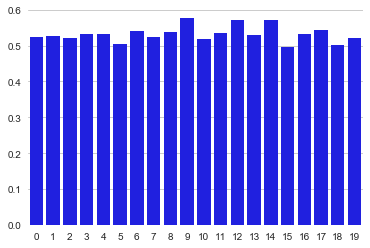

In [140]:
plt.Figure(figsize=(3,5))
sns.set(style="whitegrid")
sns.barplot(y,1-loss,color='blue')
sns.despine(left=True, bottom=True)
plt.show()